# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

## Imports

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import random

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading dataset
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

#  train validation and test
train_size = int(0.6 * len(mnist_dataset))
val_size = int(0.2 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size - val_size

# Splitting the MNIST dataset

train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create test set and define test dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?


**The only preprocessing made was "Normlization" to convert the grayscale values to tensors with numbers between 0 and 1. The image size in this dataset seems perfect - 28*28 - and we will not need to rotate images or flip them since we will predict images which are always in the right rotations (for example, number four flipped is not actually four)**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


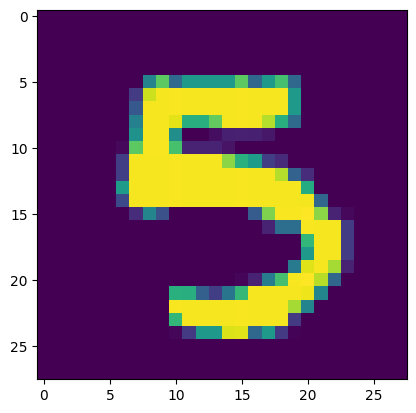

1


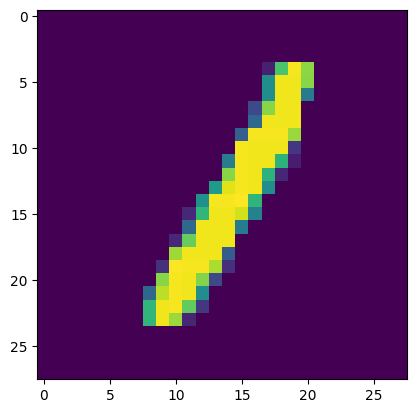

2


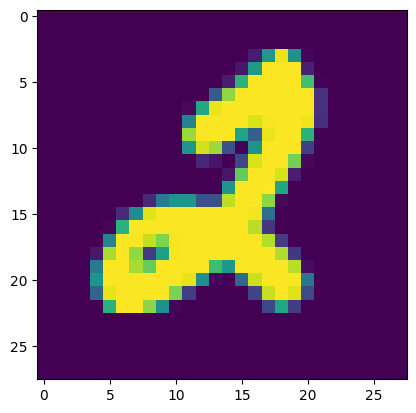

8


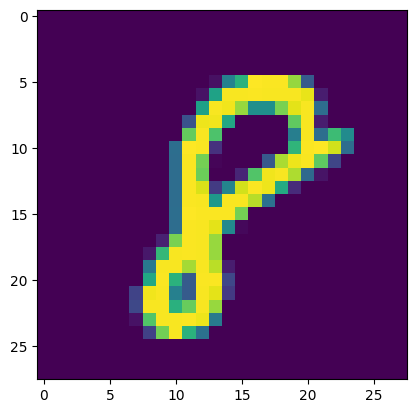

4


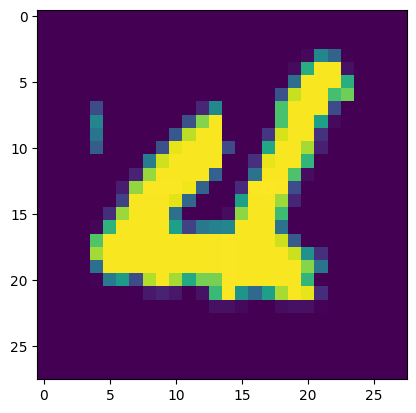

In [6]:
# Explore data
show5(train_loader)

In [11]:
# Explore data
print(len(train_dataset))
print(len(test_dataset))

36000
12000


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        x = F.softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [13]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [14]:
# Move the model to the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

Plot the training loss (and validation loss/accuracy, if recorded).

In [15]:
# epochs
num_epochs = 20
#  loss history
train_loss_history = list()
val_loss_history = list()
#  training
for epoch in range(num_epochs):
    #  training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0

    for i, data in enumerate(train_loader):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))

    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 30.33% training loss: 2.15106
Epoch 1 validation accuracy: 56.13% validation loss: 1.89682
Epoch 2 training accuracy: 56.59% training loss: 1.89380
Epoch 2 validation accuracy: 59.14% validation loss: 1.86768
Epoch 3 training accuracy: 63.42% training loss: 1.82509
Epoch 3 validation accuracy: 65.15% validation loss: 1.80686
Epoch 4 training accuracy: 67.12% training loss: 1.78812
Epoch 4 validation accuracy: 75.58% validation loss: 1.71338
Epoch 5 training accuracy: 80.26% training loss: 1.65922
Epoch 5 validation accuracy: 84.05% validation loss: 1.62702
Epoch 6 training accuracy: 87.42% training loss: 1.58900
Epoch 6 validation accuracy: 89.08% validation loss: 1.57209
Epoch 7 training accuracy: 89.79% training loss: 1.56567
Epoch 7 validation accuracy: 90.26% validation loss: 1.56105
Epoch 8 training accuracy: 91.86% training loss: 1.54570
Epoch 8 validation accuracy: 92.54% validation loss: 1.54001
Epoch 9 training accuracy: 92.71% training loss: 1.53810

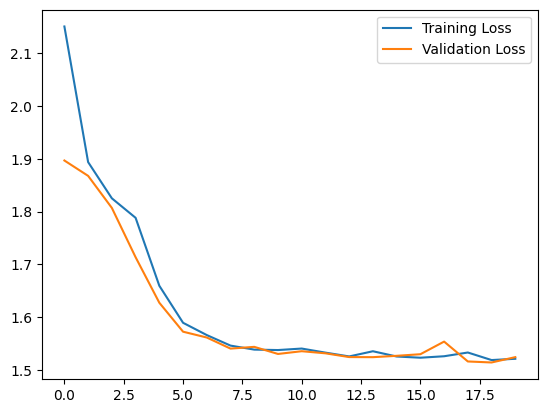

In [16]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
correct_predictions = 0
total_predictions = 0

# نقوم بتعطيل حساب التدرجات لتسريع العملية وتقليل استخدام الذاكرة
with torch.no_grad():
    for inputs, labels in test_loader:
        # نقل البيانات إلى الجهاز (GPU إذا كان متاحًا)
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        # تمرير الصور عبر النموذج
        outputs = net(inputs)

        # الحصول على الفئة ذات أعلى احتمال
        _, preds = torch.max(outputs.data, 1)

        # تحديث العدادات
        total_predictions += labels.size(0)
        correct_predictions += (preds == labels).sum().item()

accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 94.22%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

**For improving the model, I decreased the learning rate from 0.01 to 0.001. The first training phase was for finding the right weights and taking huge steps to find them. The second one - the one in the coming code cells - is to take smaller steps to fine-tune the model and get a better accuracy**

In [18]:
# exprimenting with the optimizer

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay= 0.001)

In [19]:
from tqdm import tqdm

# Number of training epochs
num_epochs = 30

# Lists to store loss history
train_loss_history = []
val_loss_history = []


for epoch in range(num_epochs):
    net.train() # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # Training phase
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Clear previous gradients
        outputs = net(inputs)# Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        _, preds = torch.max(outputs, 1)  # Get predictions
        train_correct += (preds == labels).sum().item()
        total_train += labels.size(0)
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / total_train * 100
    train_loss_history.append(avg_train_loss)

    print(f"Epoch {epoch+1} - Train Accuracy: {train_accuracy:.2f}% | Train Loss: {avg_train_loss:.5f}")

    # Validation phase
    net.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = val_correct / total_val * 100
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Val Accuracy: {val_accuracy:.2f}% | Val Loss: {avg_val_loss:.5f}\n")


Epoch 1/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 35.14it/s]


Epoch 1 - Train Accuracy: 96.17% | Train Loss: 1.50301


Epoch 1/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.97it/s]


Epoch 1 - Val Accuracy: 96.01% | Val Loss: 1.50295



Epoch 2/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 37.67it/s]


Epoch 2 - Train Accuracy: 96.81% | Train Loss: 1.49667


Epoch 2/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 35.76it/s]


Epoch 2 - Val Accuracy: 96.39% | Val Loss: 1.50065



Epoch 3/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 35.05it/s]


Epoch 3 - Train Accuracy: 97.07% | Train Loss: 1.49545


Epoch 3/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 31.53it/s]


Epoch 3 - Val Accuracy: 96.43% | Val Loss: 1.50073



Epoch 4/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 39.19it/s]


Epoch 4 - Train Accuracy: 97.18% | Train Loss: 1.49471


Epoch 4/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.14it/s]


Epoch 4 - Val Accuracy: 96.50% | Val Loss: 1.50055



Epoch 5/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 36.07it/s]


Epoch 5 - Train Accuracy: 97.31% | Train Loss: 1.49375


Epoch 5/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.75it/s]


Epoch 5 - Val Accuracy: 96.62% | Val Loss: 1.50035



Epoch 6/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.96it/s]


Epoch 6 - Train Accuracy: 97.42% | Train Loss: 1.49352


Epoch 6/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.22it/s]


Epoch 6 - Val Accuracy: 96.58% | Val Loss: 1.50054



Epoch 7/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.75it/s]


Epoch 7 - Train Accuracy: 97.39% | Train Loss: 1.49346


Epoch 7/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 42.21it/s]


Epoch 7 - Val Accuracy: 96.60% | Val Loss: 1.49992



Epoch 8/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 38.51it/s]


Epoch 8 - Train Accuracy: 97.55% | Train Loss: 1.49247


Epoch 8/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 34.20it/s]


Epoch 8 - Val Accuracy: 96.72% | Val Loss: 1.49965



Epoch 9/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 39.21it/s]


Epoch 9 - Train Accuracy: 97.56% | Train Loss: 1.49217


Epoch 9/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 37.22it/s]


Epoch 9 - Val Accuracy: 96.71% | Val Loss: 1.49967



Epoch 10/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 36.61it/s]


Epoch 10 - Train Accuracy: 97.59% | Train Loss: 1.49249


Epoch 10/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.35it/s]


Epoch 10 - Val Accuracy: 96.62% | Val Loss: 1.50087



Epoch 11/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 36.08it/s]


Epoch 11 - Train Accuracy: 97.64% | Train Loss: 1.49168


Epoch 11/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.00it/s]


Epoch 11 - Val Accuracy: 96.62% | Val Loss: 1.50022



Epoch 12/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.67it/s]


Epoch 12 - Train Accuracy: 97.73% | Train Loss: 1.49111


Epoch 12/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.06it/s]


Epoch 12 - Val Accuracy: 96.75% | Val Loss: 1.49989



Epoch 13/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.29it/s]


Epoch 13 - Train Accuracy: 97.65% | Train Loss: 1.49185


Epoch 13/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.11it/s]


Epoch 13 - Val Accuracy: 96.92% | Val Loss: 1.49915



Epoch 14/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 38.99it/s]


Epoch 14 - Train Accuracy: 97.78% | Train Loss: 1.49078


Epoch 14/30 - Validation: 100%|██████████| 94/94 [00:03<00:00, 31.26it/s]


Epoch 14 - Val Accuracy: 96.84% | Val Loss: 1.49890



Epoch 15/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 38.89it/s]


Epoch 15 - Train Accuracy: 97.90% | Train Loss: 1.48956


Epoch 15/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.63it/s]


Epoch 15 - Val Accuracy: 96.85% | Val Loss: 1.49830



Epoch 16/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 35.23it/s]


Epoch 16 - Train Accuracy: 97.93% | Train Loss: 1.48907


Epoch 16/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.53it/s]


Epoch 16 - Val Accuracy: 96.90% | Val Loss: 1.49842



Epoch 17/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.39it/s]


Epoch 17 - Train Accuracy: 97.93% | Train Loss: 1.48932


Epoch 17/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.86it/s]


Epoch 17 - Val Accuracy: 97.01% | Val Loss: 1.49839



Epoch 18/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.61it/s]


Epoch 18 - Train Accuracy: 97.94% | Train Loss: 1.48945


Epoch 18/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.84it/s]


Epoch 18 - Val Accuracy: 96.91% | Val Loss: 1.49802



Epoch 19/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 36.13it/s]


Epoch 19 - Train Accuracy: 98.02% | Train Loss: 1.48860


Epoch 19/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 37.41it/s]


Epoch 19 - Val Accuracy: 96.93% | Val Loss: 1.49824



Epoch 20/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 39.29it/s]


Epoch 20 - Train Accuracy: 98.03% | Train Loss: 1.48848


Epoch 20/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 32.74it/s]


Epoch 20 - Val Accuracy: 96.83% | Val Loss: 1.49923



Epoch 21/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 37.84it/s]


Epoch 21 - Train Accuracy: 97.98% | Train Loss: 1.48953


Epoch 21/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 37.93it/s]


Epoch 21 - Val Accuracy: 96.99% | Val Loss: 1.49770



Epoch 22/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 34.04it/s]


Epoch 22 - Train Accuracy: 98.09% | Train Loss: 1.48768


Epoch 22/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.22it/s]


Epoch 22 - Val Accuracy: 96.91% | Val Loss: 1.49828



Epoch 23/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 35.12it/s]


Epoch 23 - Train Accuracy: 98.14% | Train Loss: 1.48751


Epoch 23/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.53it/s]


Epoch 23 - Val Accuracy: 96.79% | Val Loss: 1.50006



Epoch 24/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 34.30it/s]


Epoch 24 - Train Accuracy: 98.12% | Train Loss: 1.48753


Epoch 24/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 39.90it/s]


Epoch 24 - Val Accuracy: 96.89% | Val Loss: 1.49945



Epoch 25/30 - Training: 100%|██████████| 282/282 [00:08<00:00, 34.81it/s]


Epoch 25 - Train Accuracy: 98.15% | Train Loss: 1.48769


Epoch 25/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.52it/s]


Epoch 25 - Val Accuracy: 97.12% | Val Loss: 1.49695



Epoch 26/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 38.17it/s]


Epoch 26 - Train Accuracy: 98.19% | Train Loss: 1.48653


Epoch 26/30 - Validation: 100%|██████████| 94/94 [00:03<00:00, 30.74it/s]


Epoch 26 - Val Accuracy: 97.14% | Val Loss: 1.49703



Epoch 27/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 37.93it/s]


Epoch 27 - Train Accuracy: 98.28% | Train Loss: 1.48602


Epoch 27/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 38.10it/s]


Epoch 27 - Val Accuracy: 97.05% | Val Loss: 1.49730



Epoch 28/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 36.13it/s]


Epoch 28 - Train Accuracy: 98.32% | Train Loss: 1.48581


Epoch 28/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.38it/s]


Epoch 28 - Val Accuracy: 97.04% | Val Loss: 1.49749



Epoch 29/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.59it/s]


Epoch 29 - Train Accuracy: 98.35% | Train Loss: 1.48580


Epoch 29/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 40.91it/s]


Epoch 29 - Val Accuracy: 97.17% | Val Loss: 1.49642



Epoch 30/30 - Training: 100%|██████████| 282/282 [00:07<00:00, 35.35it/s]


Epoch 30 - Train Accuracy: 98.31% | Train Loss: 1.48625


Epoch 30/30 - Validation: 100%|██████████| 94/94 [00:02<00:00, 41.21it/s]

Epoch 30 - Val Accuracy: 96.97% | Val Loss: 1.49775



## Final accuracy after tweaking the model

In [20]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.97%


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
torch.save(net.state_dict(),"model.pth")